<a href="https://colab.research.google.com/github/yfwang09/ShElastic/blob/master/examples/Case01-Uniform_Tensile_Hole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solving the spherical hole in a tensile field problem

In this notebook, we develop the spherical harmonic solution of the tensile-hole problem. The problem can be described in the following figure:

![Decompose tensile hole problem](https://github.com/yfwang09/ShElastic/blob/master/examples/figures/tensile_hole_decompose.png?raw=1)

In this approach, we only solve the image stress problem (right figure).

Here the image traction can be calculated as:

$$
\mathbf{T}^\infty = \mathbf{\sigma}\cdot\mathbf{n} = \hat{\mathbf{e}}_z S_0\cos\theta \\
\mathbf{T}^{img} = -\mathbf{T}^\infty = -\hat{\mathbf{e}}_z S_0\cos\theta =
-\hat{\mathbf{e}}_z S_0\sqrt\frac{1}{3}Y_1^0
$$

Then we set up the basic conditions of the problem:

In [1]:
# If you run this notebook on colab, run this cell
import os
codepath = '/content/ShElastic'
if not os.path.exists(codepath):
    !git clone https://github.com/yfwang09/ShElastic.git 
    !pip install pyshtools
os.chdir(os.path.join(codepath, 'examples'))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pyshtools
import sys, os
sys.path.append('..')
from shelastic.shutil import SphCoord_to_CartCoord, CartCoord_to_SphCoord
from shelastic.shutil import SHCilmToVector, lmk2K, K2lmk
import time

S0 = 1
a = 1
mu = 1
nu = 1./3

#### traction mode matrix info ####
modepath = '../shelastic/default_modes'
lJmax = 7 # max l degree for saving a single mode
lKmax = 4 # max cutoff l degree for modes
LJ = (lJmax+1)**2
LK = (lKmax+1)**2

#### create meshgrid for evaluation ####
x_grid = np.linspace(1.01, 5)
Y, X, Z = np.meshgrid([0, ], x_grid, [0, ])

R, THETA, PHI = CartCoord_to_SphCoord(X, Y, Z)

T_usr_vec = np.empty(3*LJ, dtype=np.complex)
for k in range(3):
    T_usr_cilm = pyshtools.SHCoeffs.from_zeros(lmax=lJmax, kind='complex')
    if k == 2:
        T_usr_cilm.set_coeffs(-S0/np.sqrt(3), 1, 0)
    T_usr_vec[LJ*k:LJ*(k+1)] = SHCilmToVector(T_usr_cilm.to_array(), lmax = lJmax)

#### load the full and sub matrix ####
import scipy.sparse as spm
from scipy.io import loadmat, savemat
from shelastic.shelastic import calSmode
from shelastic.shbv import generate_submat

ticT = time.time()
shtype = 'irr'
Tmodes = loadmat(os.path.join(modepath, 'Tmodes.mat'))
Cmat = generate_submat(Tmodes, mu, nu, lKmax, lJmax, shtype=shtype)
Umodes = loadmat(os.path.join(modepath, 'Umodes.mat'))
Dmat = generate_submat(Umodes, mu, nu, lKmax, lJmax, shtype=shtype)
Smodes = loadmat(os.path.join(modepath, 'Smodes.mat'))
Smodes = generate_submat(Smodes, mu, nu, lKmax, lJmax, shtype=shtype)
tocT = time.time()
print('Time for loading SH modes: %.4fs'%(tocT-ticT))

Time for loading SH modes: 0.0844s


Then we solve the linear system:

In [3]:
from shelastic.shbv import print_SH_mode
from scipy.sparse.linalg import lsqr

ticA = time.time()
A = lsqr(Cmat, T_usr_vec.transpose())
tocA = time.time()
print('Residual:', A[3], 'Time:', tocA-ticA)
A_sol = np.zeros_like(A[0])
A_sol[np.abs(A[0]) > 1e-8] = A[0][np.abs(A[0]) > 1e-8]
print('Solution:', A_sol.size)
index_sol = print_SH_mode(A_sol)

Residual: 3.132539518693837e-15 Time: 0.002273082733154297
Solution: 75
index: 1 (1, -1, 0) coeff: (-0.04523205490934833+2.1848893748264e-17j)
index: 3 (1, 1, 0) coeff: (0.04523205490934837+1.6290467636687052e-17j)
index: 11 (3, -1, 0) coeff: (-0.021661334692543284+1.9497128955659522e-17j)
index: 13 (3, 1, 0) coeff: (0.021661334692543267+1.8562913800727373e-17j)
index: 26 (1, -1, 1) coeff: (5.233894852762143e-18-0.045232054909348306j)
index: 28 (1, 1, 1) coeff: (1.0447432191609e-18-0.045232054909348375j)
index: 36 (3, -1, 1) coeff: (-7.29552747411706e-18-0.021661334692543298j)
index: 38 (3, 1, 1) coeff: (7.646970924775108e-18-0.02166133469254323j)
index: 52 (1, 0, 2) coeff: (-0.20666515317583167+1.348653981711064e-18j)
index: 62 (3, 0, 2) coeff: (0.03751853224723945-5.194403544067268e-20j)


And integrate the stress solution:

In [4]:
from shelastic.shbv import fast_stress_solution

tic = time.time()
sigma_tot = fast_stress_solution(A_sol, X, Y, Z, Smodes, lKmax, lJmax)
toc = time.time()
print(sigma_tot.shape, toc-tic)

(50, 1, 1, 3, 3) 0.019158363342285156


We compare the solution with the analytical solution of the problem:

(50, 1, 1) (50, 1, 1) (50, 1, 1)
(31, 2) [0.02620815 0.00063735 0.00114668 0.00920845 0.00335156 0.01077921
 0.00538657 0.00463259 0.00387901 0.00215444 0.00198832 0.00299757
 0.00738325 0.00462743 0.00331101 0.0079818  0.00596547 0.00693202
 0.00761445 0.0061786  0.00722109 0.00670993 0.00720561 0.00700455
 0.00669977 0.00649784 0.00627261 0.00581221 0.00471659 0.00189815
 0.00472782]


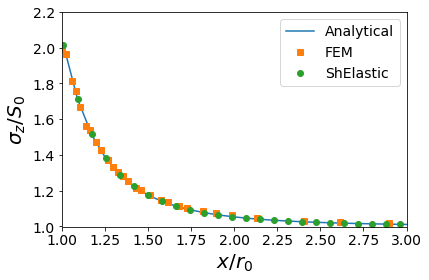

In [5]:
# Analytical result
K1 = -5*S0*a**3/2/(7-5*nu)
K2 = S0*(1-5*nu)*a**3/(7-5*nu)
A1 = S0*a**5/2/(7-5*nu)

sz = S0*(1+(4-5*nu)*a**3/2/(7-5*nu)/R**3+9*a**5/2/(7-5*nu)/R**5)
err= np.abs(sz-sigma_tot[:, :, :, 2, 2] - S0)/(sz.max())
print(X.shape, sz.shape, err.shape)

# FEM result
FEM = loadmat('../testdata/tensile_hole1.mat')['M'][::16, :]
rF = FEM[:, 0]
sz_FEM=S0*(1+(4-5*nu)*a**3/2/(7-5*nu)/rF**3+9*a**5/2/(7-5*nu)/rF**5)
err_FEM = np.abs(sz_FEM+FEM[:,1]-1)/(sz_FEM.max())

print(FEM.shape, np.abs(sz_FEM+FEM[:,1]-1)/sz_FEM)

plt.plot(X.flatten(), sz.flatten(), label='Analytical')
#plt.plot(rF, sz_FEM)
plt.plot(FEM[:, 0], -FEM[:, 1]+1, 's', label='FEM')
total_time = 1000*(toc-tic + tocA-ticA) #+ tocT-ticT
plt.plot(X.flatten(), sigma_tot[:, :, :, 2, 2].flatten() + S0, 'o',label='ShElastic')
plt.legend(fontsize=14)
plt.xlabel(r'$x/r_0$', fontsize=20)
plt.ylabel(r'$\sigma_z/S_0$', fontsize=20)
plt.xlim(1, 3)
plt.ylim(1, 2.2)
plt.tick_params(labelsize=14)
plt.tight_layout()
plt.savefig('../figures/case1-result.png') #, dpi=1000), transparent=True)
plt.show()

In [6]:
from scipy.io import savemat, whosmat

n = 3
filename = '../figures/case1-result.mat'
obj_x = np.empty((n,), dtype=np.object)
obj_y = np.empty((n,), dtype=np.object)
obj_e = np.empty((n,), dtype=np.object)
obj_label = np.empty((n,), dtype=np.object)

obj_x[0], obj_x[1], obj_x[2] = (X.flatten(), FEM[:, 0], X.flatten())
obj_y[0], obj_y[1], obj_y[2] = (sz.flatten(), -FEM[:, 1]+1, sigma_tot[:, :, :, 2, 2].flatten() + S0)
obj_e[0], obj_e[1], obj_e[2] = (X.flatten()*0, err_FEM, err.flatten())
obj_label[0] = 'Analytical'
obj_label[1] = 'FEM'
obj_label[2] = 'ShElastic'

savemat(filename, {'X': obj_x, 'Y': obj_y,'E': obj_e, 'label': obj_label})
whosmat(filename)

[('X', (1, 3), 'cell'),
 ('Y', (1, 3), 'cell'),
 ('E', (1, 3), 'cell'),
 ('label', (1, 3), 'cell')]

## Elastic Energy

We then calculate the corresponding elastic energy:

In [7]:
Uvec = Dmat.dot(A_sol)

E=2*np.pi*np.vdot(Uvec, T_usr_vec) #np.multiply(Uvec, T_usr_vec).sum()
print('total elastic energy from SH:', E)

total elastic energy from SH: (-0.785398163397448-4.7337841576759565e-18j)


In [8]:
Emodes = np.dot(A_sol, 2*np.pi*Cmat.multiply(Dmat.conjugate()).sum(axis=0).T).flatten()
print('total elastic energy from summing up SH modes', Emodes)

total elastic energy from summing up SH modes [[-0.5739857+12.21459631j]]


In [9]:
Ngrid = 30
latglq, longlq = pyshtools.expand.GLQGridCoord(Ngrid)
theta = np.radians(90-latglq)
phi = np.radians(longlq)
#print(theta)
#print(phi)
dtheta = np.gradient(theta)
dphi = np.gradient(phi)
#zero, w = pyshtools.expand.SHGLQ(lmax_sub)

TT, PP = np.meshgrid(theta, phi)
dT, dP = np.meshgrid(dtheta, dphi)
dA = np.sin(TT)*dT*dP
ZZ = np.cos(TT)
XX = np.sin(TT)*np.cos(PP)
YY = np.sin(TT)*np.sin(PP)
RR = np.sqrt(XX**2+YY**2+ZZ**2)
NN = np.stack((XX/RR, YY/RR, ZZ/RR), axis=-1)

In [10]:
from shelastic.shbv import fast_displacement_solution, fast_stress_solution
Umesh = fast_displacement_solution(A_sol, XX, YY, ZZ, Dmat, lKmax, lJmax)
Smesh = fast_stress_solution(A_sol, XX, YY, ZZ, Smodes, lKmax, lJmax)
Tmesh = np.sum(Smesh*NN[...,np.newaxis,:], axis=-1)

In [11]:
W = (1/2*np.sum(Umesh*Tmesh, axis=-1)*dA).sum()
print('numerical elastic energy:', W*mu/S0**2)
print('total elastic energy from SH:', E*mu/S0**2)
print('total elastic energy from summing up SH modes', Emodes*mu/S0**2)

numerical elastic energy: (-0.7854806313860262+4.734693324518527e-18j)
total elastic energy from SH: (-0.785398163397448-4.7337841576759565e-18j)
total elastic energy from summing up SH modes [[-0.5739857+12.21459631j]]


This shows that the total elastic energy is different from the sum of per-mode elastic energy. If we calculate the cross terms of the energy, and trying to find energy eigen states:

(75,) (75, 75)


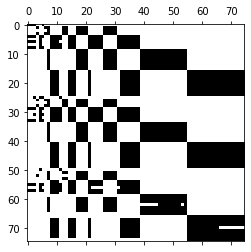

In [12]:
Ecross = 2*np.pi*Dmat.H*Cmat
A = Ecross.todense()
w,v = np.linalg.eig(A)
print(w.shape, v.shape)
plt.spy(v,precision=1e-5)
plt.show()

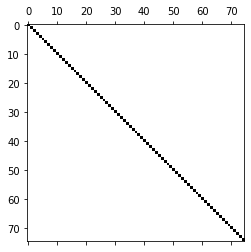

In [13]:
plt.spy(np.linalg.inv(v).dot(A).dot(v),precision=1e-8)
plt.show()

In [14]:
print(np.diag(np.linalg.inv(v).dot(A).dot(v)).real)

[  -8.2894344  -207.43326114 -207.43326114  -84.4739358  -207.43326114
   -8.2894344   -33.51032164 -431.47400186 -796.44144542 -796.44144542
 -796.44144542   -8.2894344   -33.51032164  -33.51032164 -796.44144542
 -796.44144542 -796.44144542 -431.47400186 -431.47400186 -431.47400186
 -431.47400186 -796.44144542  -44.68042885  -44.68042885  -44.68042885
  -44.68042885  -11.70000181  -11.70000181  -11.70000181  -11.70000181
  -11.70000181  -44.68042885  -15.1865233   -15.1865233   -15.1865233
  -15.1865233   -15.1865233   -15.1865233   -15.1865233   -55.85053606
  -55.85053606  -55.85053606  -55.85053606  -55.85053606  -55.85053606
 -250.39657002 -250.39657002 -250.39657002 -250.39657002 -250.39657002
 -250.39657002 -250.39657002 -250.39657002  -55.85053606 -250.39657002
 -469.08103642 -469.08103642 -469.08103642 -469.08103642 -469.08103642
 -469.08103642 -469.08103642 -469.08103642 -469.08103642 -469.08103642
 -469.08103642  -67.02064328  -67.02064328  -67.02064328  -67.02064328
  -67.0